In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

In [38]:
ds = pd.read_csv(r'C:\Users\jmfra\OneDrive\Documents\Thinkful Data Science Files\1.5.1 data\armenian_pubs.csv')
ds = ds.drop('Timestamp', axis=1)
ds['Occupation'] = ds.Occupation.str.strip()
ds['Fav_Pub'] = ds.Fav_Pub.str.strip()
ds['Fav_Pub'] = ds.Fav_Pub.str.lower()
ds['Fav_Pub'] = ds.Fav_Pub.str.replace('^the ','')
ds['Fav_Pub'] = ds.Fav_Pub.str.replace('i have none','do not have one')
ds['Fav_Pub'] = ds.Fav_Pub.str.replace('37 pub','pub 37')
ds['Freq'] = ds.Freq.str.replace('Several times in a month','Sometimes')
ds['Freq'] = ds.Freq.str.replace('^rarely.+','Rarely')
ds['Freq'] = ds.Freq.str.replace('Several times a week','Often')
ds['Lifestyle'] = ds.Lifestyle.str.strip()
ds['Lifestyle'] = ds.Lifestyle.str.replace('^Adventur.+','Adventurous')
ds['Lifestyle'] = ds.Lifestyle.str.replace('^Busy.+','Busy')
ds['Lifestyle'] = ds.Lifestyle.str.replace('^Rock.+','Musical')
ds['Lifestyle'] = ds.Lifestyle.str.replace('^Business.+','Active')
ds['Lifestyle'] = ds.Lifestyle.str.replace('^Sport\,.+','Active')
ds['Lifestyle'] = ds.Lifestyle.str.replace('^Art','Artsy')
ds['WTS'] = ds['WTS'].fillna(ds['WTS'].median())
print(ds)

     Age  Gender    Income         Occupation             Fav_Pub      WTS  \
0     19    Male  100000.0            Student             station   2000.0   
1     19  Female   50000.0            Student             calumet   2000.0   
2     20    Male  100000.0            Student             liberty   3000.0   
3     18    Male       0.0            Student             calumet   3000.0   
4     19  Female  130000.0  Student + working             liberty  10000.0   
5     19    Male   90000.0            Student             station   2000.0   
6     18  Female       0.0            Student               irish   1000.0   
7     19  Female       0.0            Student             station   2000.0   
8     19    Male   80000.0  Student + working   i don't like pubs  10000.0   
9     19    Male  150000.0            Student               irish   3000.0   
10    20  Female   80000.0            Student   i don't like pubs   3000.0   
11    18    Male   90000.0            Student               venu

Using a dataset of your choice, select an outcome variable and then pick four or five other variables (one to two categorical, three to four continuous) to act as the basis for features.

## Outcome variable: Favorite Pub

## Categorical Variables: Gender, Occupation

## Continous variables: Income, Age, Willingness To Spend

Next, based on what you learned via your data exploration, create ten new features. Explain the reasoning behind each one.

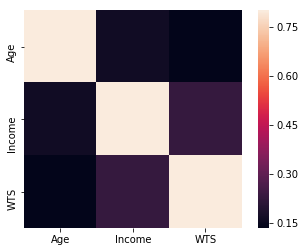

In [39]:
corrmat = ds.corr()
f, ax = plt.subplots()
sns.heatmap(corrmat, vmax = .8, square=True)
plt.show()

In [40]:
#There are a few inputs that are specific jobs, but mose are general categories, so let's group into students and non students
test = pd.get_dummies(ds['Occupation'])
test['InSchool'] = np.where((ds['Occupation'].isin(['Student', 'Student + working'])), 1, 0)
ds['InSchool'] = np.where((ds['Occupation'].isin(['Student', 'Student + working'])), 1, 0)
print(pd.crosstab(test['InSchool'], ds['Occupation']))
print(ds['Occupation'].groupby(test['InSchool']).size())

Occupation  CEO  Entrepreneur / Software Engineer  Student  Student + working  \
InSchool                                                                        
0             1                                 1        0                  0   
1             0                                 0      122                 40   

Occupation  Working  army  
InSchool                   
0                10     1  
1                 0     0  
InSchool
0     13
1    162
Name: Occupation, dtype: int64


In [41]:
#turning Gender into a usable classification
ds['Gender_classifier'] = np.where(ds['Gender'].isin(['Male']),1,0)
print(ds['Gender_classifier'].groupby(ds['Gender_classifier']).size())

Gender_classifier
0    102
1     73
Name: Gender_classifier, dtype: int64


In [42]:
#we would assume that age plays a huge part in bar selection, so seperating it into college age students and below college age 
#can probably tell us what age range enjoys specific environments
ds['Over18'] = np.where(ds['Age']>18, 1, 0)
print(ds['Age'].groupby(ds['Over18']).size())

Over18
0     61
1    114
Name: Age, dtype: int64


In [43]:
#making Willingness to sell into an easier to use category
ds['WTS_Interval'] = pd.cut(ds.WTS, 
                            bins=[-1,2000,4000,6000,8000,10000,1000000], 
                            labels=[1,2,3,4,5,6])
wts_interval = ds.groupby('WTS_Interval').size()
print(wts_interval)

WTS_Interval
1    51
2    44
3    48
4     8
5    16
6     8
dtype: int64


In [44]:
#identical to the cell above
ds['Income_Interval'] = pd.cut(ds.Income, 
                               bins=[-1,25000,50000,75000,100000,125000,150000,175000,200000,
                                     300000,400000,500000,600000,700000,800000,900000,1000000,
                                     50000000], 
                               labels=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])
income_interval = ds.groupby('Income_Interval').size()
print(income_interval)

Income_Interval
1     56
2     30
3     18
4     30
5      6
6     10
7      1
8     11
9      6
10     2
11     0
12     0
13     1
14     0
15     2
16     0
17     1
dtype: int64


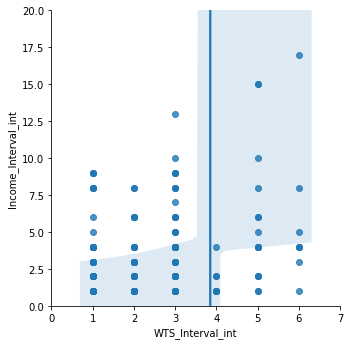

In [45]:
#comparing willingness to sell to income to see if there is a high correlation between the two as we would expect
ds['WTS_Interval_int'] = ds['WTS_Interval'].astype(int)
ds['Income_Interval_int'] = ds['Income_Interval'].astype(int)
ax = sns.lmplot(y='Income_Interval_int', x='WTS_Interval_int', data=ds)
ax.set(xlim=(0, 7))
ax.set(ylim=(0, 20))
plt.show()
means = ds[['WTS_Interval_int','Income_Interval_int']].mean(axis=0)
stds = ds[['WTS_Interval_int','Income_Interval_int']].std(axis=0)
ds['WTS+Income'] = ((ds[['WTS_Interval_int','Income_Interval_int']] - means) / stds).mean(axis=1)

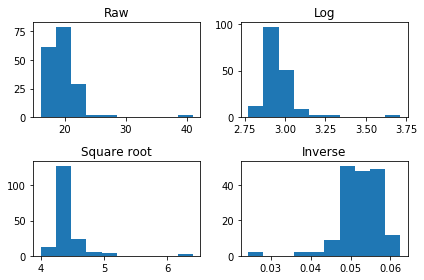

In [46]:
#testing to see if reforming age makes it easier to work with
fig = plt.figure()

fig.add_subplot(221)
plt.hist(ds['Age'].dropna())
plt.title('Raw')

fig.add_subplot(222)
plt.hist(np.log(ds['Age'].dropna()))
plt.title('Log')

fig.add_subplot(223)
plt.hist(np.sqrt(ds['Age'].dropna()))
plt.title('Square root')

ax3=fig.add_subplot(224)
plt.hist(1/ds['Age'].dropna())
plt.title('Inverse')
plt.tight_layout()
plt.show()

In [47]:
#age and whether or not a person is in school is the highest correlated variable to lets combine them
means = ds[['Age','InSchool']].mean(axis=0)
stds = ds[['Age','InSchool']].std(axis=0)
ds['School+Age'] = ((ds[['Age','InSchool']] - means) / stds).mean(axis=1)

In [48]:
#combining all continuous variables because we would expecct them to be correlated
means = ds[['Age','WTS','Income']].mean(axis=0)
stds = ds[['Age','WTS','Income']].std(axis=0)
ds['continuous'] = ((ds[['Age','WTS','Income']] - means) / stds).mean(axis=1)

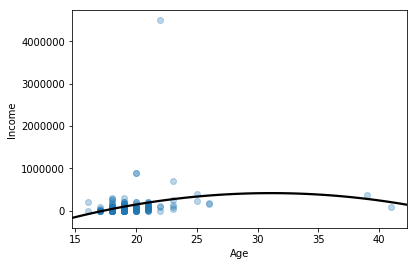

In [49]:
sns.regplot(
    ds['Age'],
    y=ds['Income'],
    y_jitter=.49,
    order=2,
    scatter_kws={'alpha':0.3},
    line_kws={'color':'black'},
    ci=None
)
plt.show()

ds['age_squared'] = ds['Age'] * ds['Age']

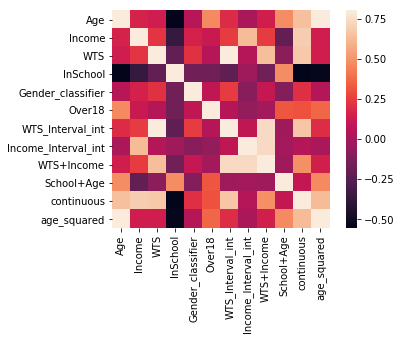

In [50]:
corrmat = ds.corr()
f, ax = plt.subplots()
sns.heatmap(corrmat, vmax = .8, square=True)
plt.show()

Finally, use filtering methods to select the five best features and justify your choices.

It looks like the top 5 features to use are School+age, Gender, WTS+Income, Over18, and Income.
I chose these because they encompass all of the variables while combining week variables from the original data into categories that would likley provide a correlation. None of the variables besides Age and whether or not they are in school have high correlations to begin with becuase of the small sample size, so I chose them logically.